In [28]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pyro
import numpy
import jax

정규모형 분산은 하프코시분포포

In [29]:
n = 500
mu =2
sigma = 1.0
y = mu + sigma*jax.random.normal(jax.random.PRNGKey(0), (n,))

이 모형을 넘파이로에서 어떻게 정의할까?

In [30]:
import numpyro as npr
import numpyro.distributions as dist

def normal_model(y):
    #모델 파라미터들을 정의(사전분포) -> 프라이어
    mu = npr.sample('mu', dist.Normal(0, 10))
    sigma = npr.sample('sigma', dist.HalfNormal(10))
    #관측값에 대한 확률분포를 정의(가능도) -> 라이클리후드드
    with npr.plate('data', len(y)):
        npr.sample('obs', dist.Normal(mu, sigma), obs=y)

In [31]:
#그렇다면 헤밀토니안 몬테카를로는 어떻게 정의할까?
from numpyro.infer import MCMC, NUTS
kernel = NUTS(normal_model)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=10000, num_chains=2)
mcmc.run(jax.random.PRNGKey(1), y=y)

C:\Users\JWY\AppData\Local\Temp\ipykernel_27816\1973267201.py:4: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=5000, num_samples=10000, num_chains=2)
sample:  92%|█████████▏| 13832/15000 [00:03<00:00, 3533.10it/s, 3 steps of size 7.70e-01. acc. prob=0.93]


KeyboardInterrupt: 

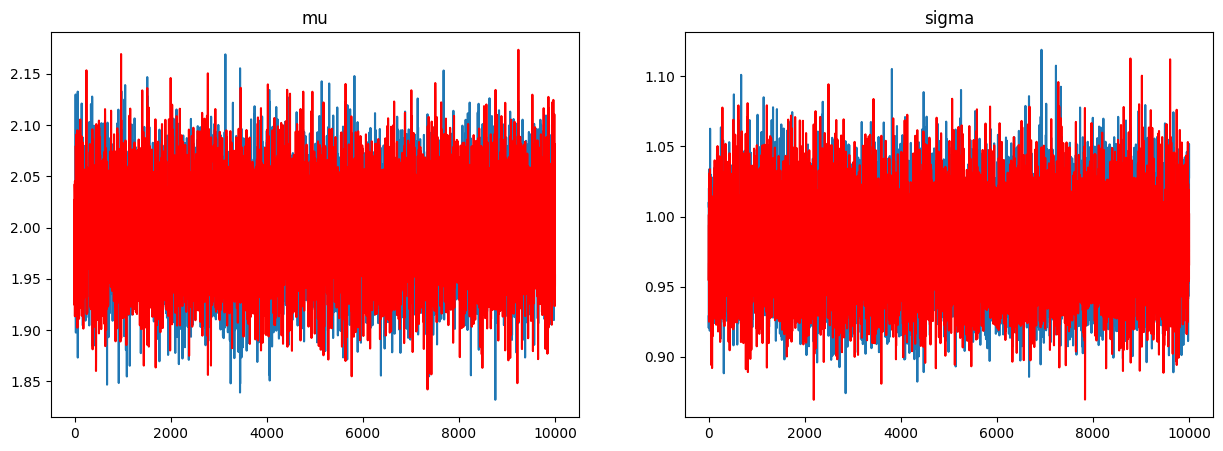

In [ ]:
#사후표본 추출
ps = mcmc.get_samples(group_by_chain=True) #알고리즘이 다 작동된 후 표본을 꺼내서 추론해야 함함
import matplotlib.pyplot as plt
#자취그림 (샘플을 그려서 파라미터의 분포를 시각화)
#mu와 sigma의 사후분포를 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(ps['mu'][0]);ax1.plot(ps['mu'][1],'r')
ax1.set_title('mu')
ax2.plot(ps['sigma'][0]);ax2.plot(ps['sigma'][1],'r')
ax2.set_title('sigma')
plt.show()

In [ ]:
#수렴성을 판단하는 통계량도 사용가능(겔만-루빈 통계량) ,1에 가까울수록 수렴
#numpyro.diagnostics 모듈에 정의되어 있음
from numpyro.diagnostics import gelman_rubin
gelman_rubin(ps['mu']), gelman_rubin(ps['sigma'])

#유효 표본수 (내가 추출한 표본이 independent 표본과 얼마나 유사한가를 나타내는 지표)
#유효 표본수가 높을수록 독립적인 표본과 유사하다는 의미 - 주로 1000 기준
from numpyro.diagnostics import effective_sample_size
effective_sample_size(ps['mu']), effective_sample_size(ps['sigma'])

(np.float64(16593.187665542417), np.float64(16781.336618226804))

In [ ]:
#요약통계량 n_eff :effective sample size, r_hat : gelman-rubin statistic
#numpyro.infer.mcmc.MCMC 클래스의 print_summary 메서드를 사용하여 요약통계량을 출력할 수 있음
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      2.00      0.04      2.00      1.93      2.07  16593.19      1.00
     sigma      0.98      0.03      0.98      0.93      1.03  16781.34      1.00

Number of divergences: 0


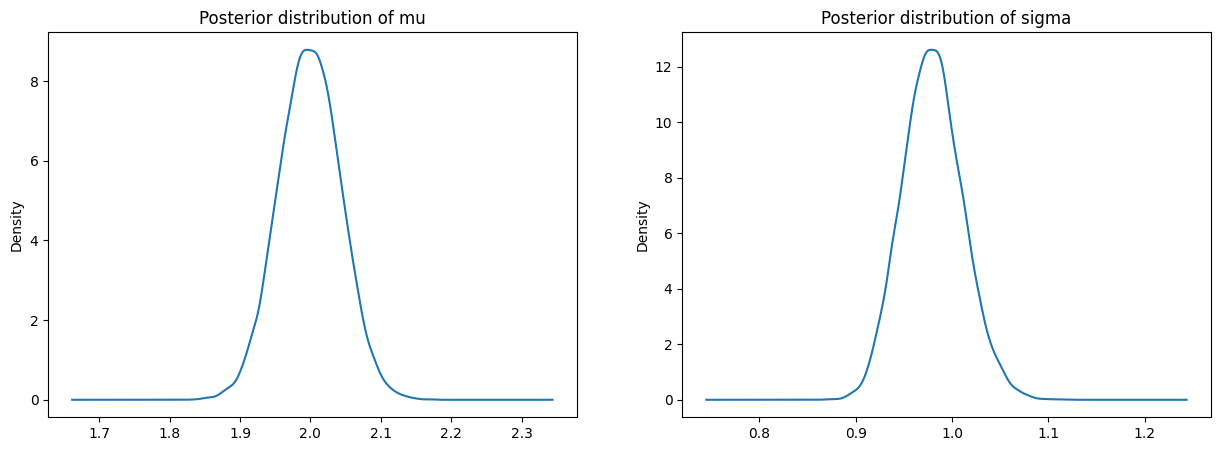

In [ ]:
#사후분포 그림 그리기
import pandas as pd
ps = mcmc.get_samples()
psd = pd.DataFrame(ps)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1);psd['mu'].plot.kde()
plt.title('Posterior distribution of mu')
plt.subplot(1,2,2);psd['sigma'].plot.kde()
plt.title('Posterior distribution of sigma')
plt.show()

변분방법 공부

In [ ]:
from numpyro.infer.autoguide import AutoDiagonalNormal
#자동으로 사전분포를 정의하는 오토가이드를 사용하여 모델을 정의할 수 있음
from numpyro.infer.autoguide import AutoMultivariateNormal #모수들간의 correlation을 고려한 다변량 정규분포를 사용하여 사전분포를

guide = AutoDiagonalNormal(normal_model)#mean-field 사전분포를 사용하여 사전분포를 정의
#guide = AutoMultivariateNormal(normal_model)  # 다변량 정규분포를 사용하여 사전분포를 정의할 수도 있음
#guide = AutoLaplaceApproximation(normal_model) #라플라스 근사법을 사용하여 사전분포를 정의할 수도 있음
#guide = AutoLowRankMultivariateNormal(normal_model) #저랭크 다변량 정규분포를 사용하여 사전분포를 정의할 수도 있음



In [ ]:
from numpyro.infer import SVI, Trace_ELBO
from numpyro.optim import Adam
#최적화를 위한 아담 옵티마이저 설정
optimizer = Adam(step_size=0.001)

#SVI 객체 생성
svi = SVI(normal_model, guide, optimizer, loss=Trace_ELBO()) #수렴성 판단 ELBO 손실함수 사용
#SVI 실행
n_steps = 1000
svi_state = svi.init(jax.random.PRNGKey(0), y=y)  # 초기 상태 설정

#최적화 루프
elbo_values = []
for step in range(n_steps):
    svi_state, elbo = svi.update(svi_state, y=y)  # 파라미터 업데이트
    elbo_values.append( -elbo)  # ELBO 값 저장
    if step % 1000 == 0:
        print('step {}: ELBO = {}'.format(step, elbo))

step 0: ELBO = 1186.978271484375


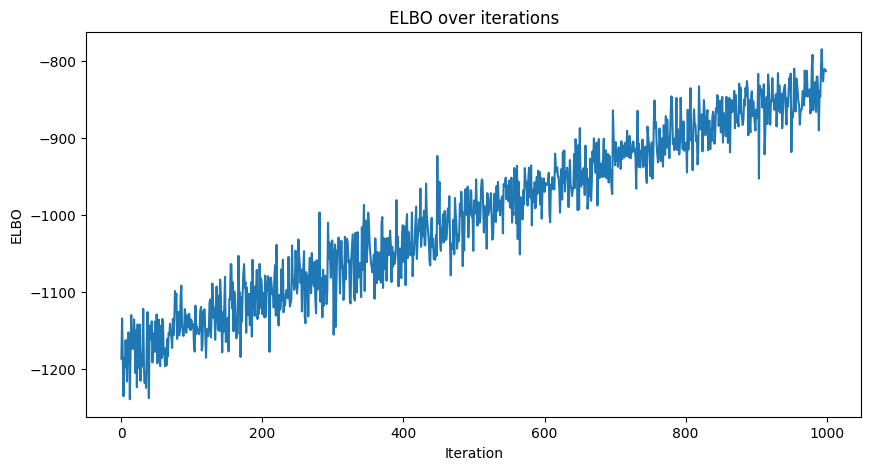

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(elbo_values)
plt.title('ELBO over iterations')
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.show()

In [ ]:
params = svi.get_params(svi_state)  # 최적화된 파라미터 추출, 모수에대한 변분모수들을 알려줌
print(params)


{'auto_loc': Array([1.3163182 , 0.40050426], dtype=float32), 'auto_scale': Array([0.10111757, 0.08732274], dtype=float32)}


추가 예제 :베이지안 정규모형을 바탕으로 살펴보기
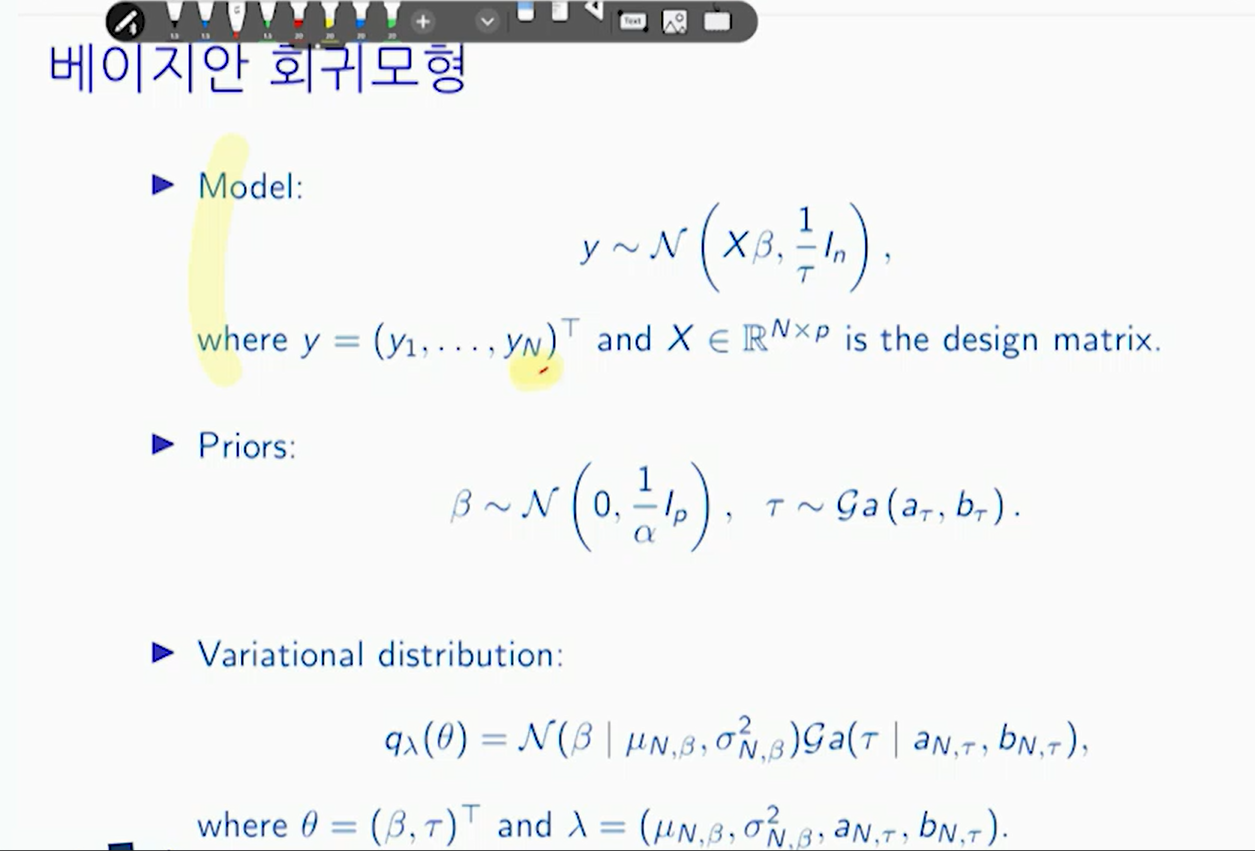
변분추론에서 핵심인 부분은 변분분포를 살펴보는 것
뮤/시그마/a/n



In [ ]:
import pandas as pd
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=';')
dset.head(10) #반응변수 :'Divorce'

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440


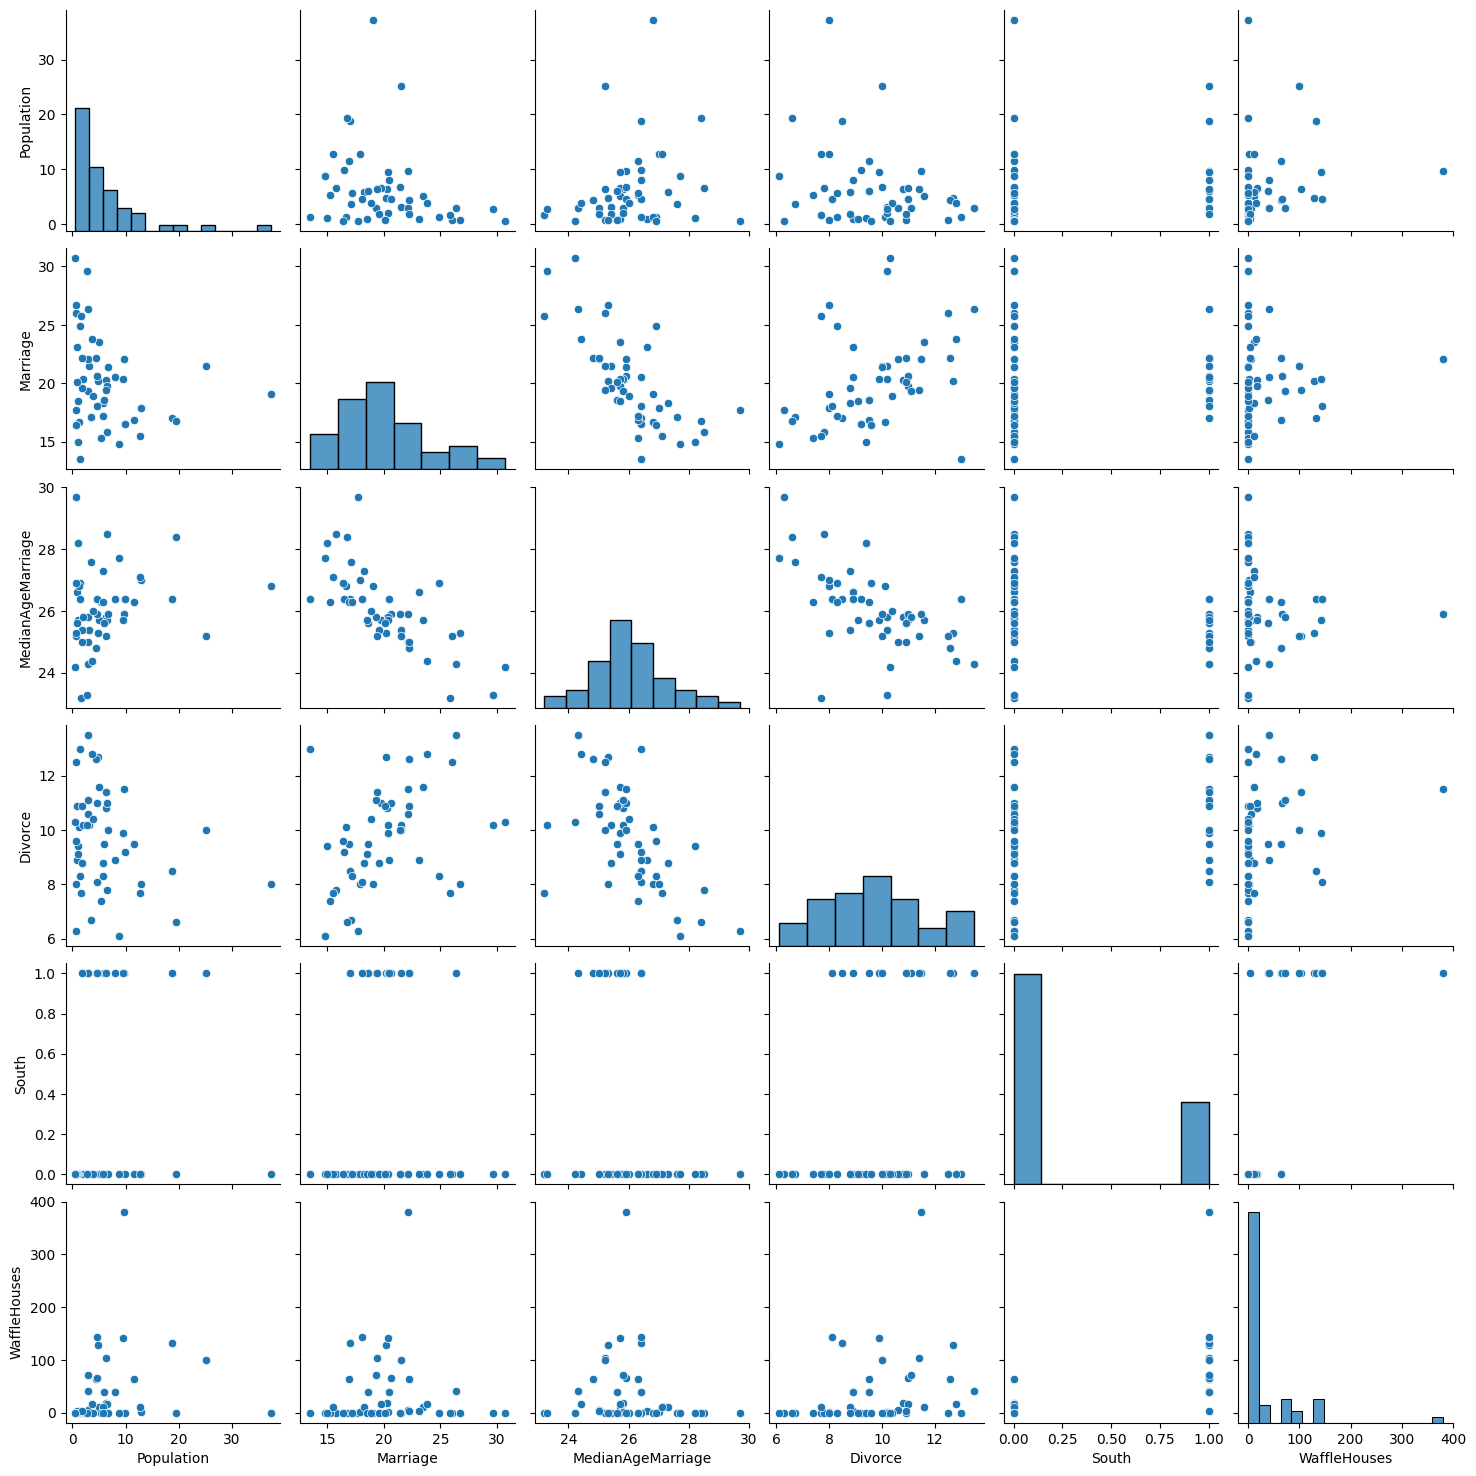

In [ ]:
import seaborn as sns

vars = [
    'Population', 
    'Marriage', 
    'MedianAgeMarriage', 
    'Divorce',
    'South',
    'WaffleHouses'
    ]
sns.pairplot(dset , x_vars = vars , y_vars=vars); #패턴에 대해 살펴보기 위해 행렬산점도 그려봄- 대략적인 변수간 상관관계

In [ ]:
standardize = lambda x: (x - x.mean()) / x.std()  # 표준화 함수
# 표준화된 데이터셋 생성
dset["AgeScaled"] = dset.MedianAgeMarriage.pipe(standardize)
dset["DivorceScaled"] = dset.Divorce.pipe(standardize)
dset["MarriageScaled"] = dset.Marriage.pipe(standardize)

In [ ]:
#회귀모형 정의 (가능도와 , 사전분포(프라이어) 정의)
import jax
import numpyro
import numpyro.distributions as dist

def regmodel(marriage =None, divorce = None):
    a = numpyro.sample('a', dist.Normal(0, 10))  # 절편
    bM = numpyro.sample('bM', dist.Normal(0, 10))  # 결혼에 대한 기울기
    M = bM*marriage  # 결혼에 대한 기울기와 결혼 변수의 곱 ,설명변수 
    tausq = numpyro.sample('tausq', dist.InverseGamma(0.01, 0.01))  # 오차의 분산 (감마분포의 역수로 정의)
    # InverseGamma(0.01, 0.01) : 사전분포로 사용되는 역감마분포
    sigma = jax.numpy.sqrt(1/tausq)  # 표준편차
    mu = a + M  # 평균
    with numpyro.plate('data', len(divorce)):
        numpyro.sample('obs', dist.Normal(mu, sigma), obs=divorce)  # 관측값에 대한 확률분포 정의


In [ ]:
#변분분포 모델 정의 하는 부분이 필요
def guide(marriage=None, divorce=None):
    #tau 분산(의 역수수)
    alpha_tau = numpyro.param("alpha_tau",1.,constraints = dist.constraints.positive)
    beta_tau = numpyro.param("beta_tau",1.,constraints = dist.constraints.positive)
    numpyro.sample("tausq", dist.Gamma(alpha_tau, beta_tau))  # tausq에 대한 변분분포 정의

    #a 회귀계수(절편) normal 분포로 정의
    #numpyro.param를 사용하여 변분분포의 파라미터를 정의
    loc_a = numpyro.param("loc_a", 0.)
    scale_a = numpyro.param("scale_a", 1., constraints=dist.constraints.positive)
    numpyro.sample("a", dist.Normal(loc_a, scale_a))  # a에 대한 변분분포 정의

    #bM 회귀계수(기울기기)
    loc_b = numpyro.param("loc_b", 0.)
    scale_b = numpyro.param("scale_b", 1., constraints=dist.constraints.positive)
    numpyro.sample("bM", dist.Normal(loc_b, scale_b))  # bM에 대한 변분분포 정의


In [ ]:
#최적화 방법
from numpyro.infer import SVI, Trace_ELBO
from numpyro.optim import Adam
optimizer = Adam(step_size=0.01)  # 아담 옵티마이저 설정
#SVI 객체 생성
svi = SVI(regmodel, guide, optimizer, loss=Trace_ELBO())  # SVI 객체 생성 (변분하한, 증거하한)
#SVI 실행
n_steps = 1000
svi_state = svi.init(jax.random.PRNGKey(0), marriage=dset.MarriageScaled, divorce=dset.DivorceScaled)  # 초기 상태 설정
#최적화 루프
elbo_values = []
for step in range(n_steps):
    svi_state, elbo = svi.update(svi_state, marriage=dset.MarriageScaled, divorce=dset.DivorceScaled)  # 파라미터 업데이트
    elbo_values.append(-elbo)  # ELBO 값 저장
    if step % 100 == 0:
        print('step {}: ELBO = {}'.format(step, elbo))

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float32[50]
See https://docs.jax.dev/en/latest/errors.html#jax.errors.TracerArrayConversionError